# JRE-1169-ElonMusk NLP-EDA-V1

Link to Data: https://www.kaggle.com/datasets/christianlillelund/joe-rogan-experience-1169-elon-musk

### Necessary Imports

In [156]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

### Read in CSV with conversation transcript data

In [157]:
df = pd.read_csv('JRE-1169-Musk.csv')

df

,Timestamp,Speaker,Text
0,[00:00:00],Joe Rogan,"Ah, ha, ha, ha. Four, three, two, one, boom. T..."
1,[00:00:09],Elon Musk,You're welcome.
2,[00:00:10],Joe Rogan,It's very good to meet you.
3,[00:00:11],Elon Musk,Nice to meet you too.
4,[00:00:12],Joe Rogan,And thanks for not lighting this place on fire.
...,...,...,...
1826,[02:36:41],Joe Rogan,"I believe it's true too. So, thank you."
1827,[02:36:43],Elon Musk,You're welcome.
1828,[02:36:44],Joe Rogan,"All you assholes out there, be nice. Be nice, ..."
1829,[02:36:50],Elon Musk,"All right, thank you."


In [158]:
df_id=[]
for i in range(len(df.index)):
    df_id.append(i)
df['ID'] = df_id
df = df[['ID','Timestamp','Speaker','Text']]
df

,ID,Timestamp,Speaker,Text
0,0,[00:00:00],Joe Rogan,"Ah, ha, ha, ha. Four, three, two, one, boom. T..."
1,1,[00:00:09],Elon Musk,You're welcome.
2,2,[00:00:10],Joe Rogan,It's very good to meet you.
3,3,[00:00:11],Elon Musk,Nice to meet you too.
4,4,[00:00:12],Joe Rogan,And thanks for not lighting this place on fire.
...,...,...,...,...
1826,1826,[02:36:41],Joe Rogan,"I believe it's true too. So, thank you."
1827,1827,[02:36:43],Elon Musk,You're welcome.
1828,1828,[02:36:44],Joe Rogan,"All you assholes out there, be nice. Be nice, ..."
1829,1829,[02:36:50],Elon Musk,"All right, thank you."


### Seperate initial dataframe into Elon and Joe dataframes

In [159]:
df_joe = df[df['Speaker']=="Joe Rogan"]
df_joe

,ID,Timestamp,Speaker,Text
0,0,[00:00:00],Joe Rogan,"Ah, ha, ha, ha. Four, three, two, one, boom. T..."
2,2,[00:00:10],Joe Rogan,It's very good to meet you.
4,4,[00:00:12],Joe Rogan,And thanks for not lighting this place on fire.
6,6,[00:00:16],Joe Rogan,"How does one, just in the middle of doing all ..."
8,8,[00:01:02],Joe Rogan,"Now, who-"
...,...,...,...,...
1822,1822,[02:36:21],Joe Rogan,I couldn't agree more. And I want to thank you...
1824,1824,[02:36:40],Joe Rogan,And I believe it.
1826,1826,[02:36:41],Joe Rogan,"I believe it's true too. So, thank you."
1828,1828,[02:36:44],Joe Rogan,"All you assholes out there, be nice. Be nice, ..."


In [160]:
df_elon = df[df['Speaker']=="Elon Musk"]
df_elon

,ID,Timestamp,Speaker,Text
1,1,[00:00:09],Elon Musk,You're welcome.
3,3,[00:00:11],Elon Musk,Nice to meet you too.
5,5,[00:00:13],Elon Musk,You're welcome. That's coming later.
7,7,[00:00:30],Elon Musk,"Well, the flame, we didn't put a lot of time i..."
9,9,[00:01:02],Elon Musk,"And then, we have a merchandise section that o..."
...,...,...,...,...
1821,1821,[02:35:53],Elon Musk,"No. I think, you know, I think people should b..."
1823,1823,[02:36:40],Elon Musk,It's true.
1825,1825,[02:36:41],Elon Musk,It's true.
1827,1827,[02:36:43],Elon Musk,You're welcome.


### Add sentiment analysis to dataframes

## VADER Sentiment Scoring (Valence Aware Dictionary and sEntiment Reasoner)

In [161]:
sia = SentimentIntensityAnalyzer()

In [162]:
# Run the sia polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1831 [00:00<?, ?it/s]

In [163]:
vaders = pd.DataFrame(res).T 
vaders = vaders.reset_index().rename(columns={'index':'ID'})
vaders = vaders.merge(df, how='left') 

vaders.head()

,ID,neg,neu,pos,compound,Timestamp,Speaker,Text
0,0,0.000,0.455,0.545,0.9273,[00:00:00],Joe Rogan,"Ah, ha, ha, ha. Four, three, two, one, boom. T..."
1,1,0.000,0.250,0.750,0.4588,[00:00:09],Elon Musk,You're welcome.
2,2,0.000,0.610,0.390,0.4927,[00:00:10],Joe Rogan,It's very good to meet you.
3,3,0.000,0.588,0.412,0.4215,[00:00:11],Elon Musk,Nice to meet you too.
4,4,0.195,0.569,0.236,0.1280,[00:00:12],Joe Rogan,And thanks for not lighting this place on fire.


#### Plot VADER results for whole conversation

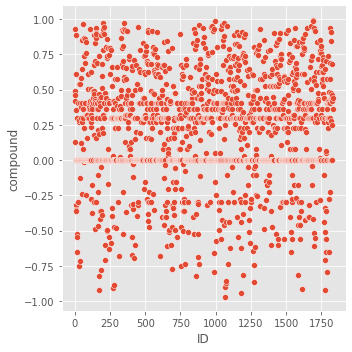

In [164]:
ax = sns.relplot(data=vaders, x="ID", y="compound")

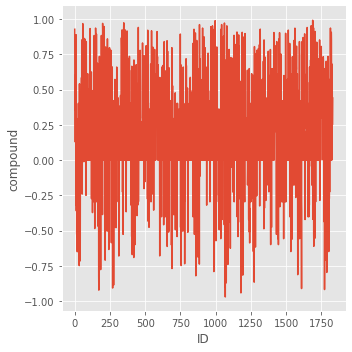

In [165]:
ax = sns.relplot(data=vaders, x="ID", y="compound", kind="line")

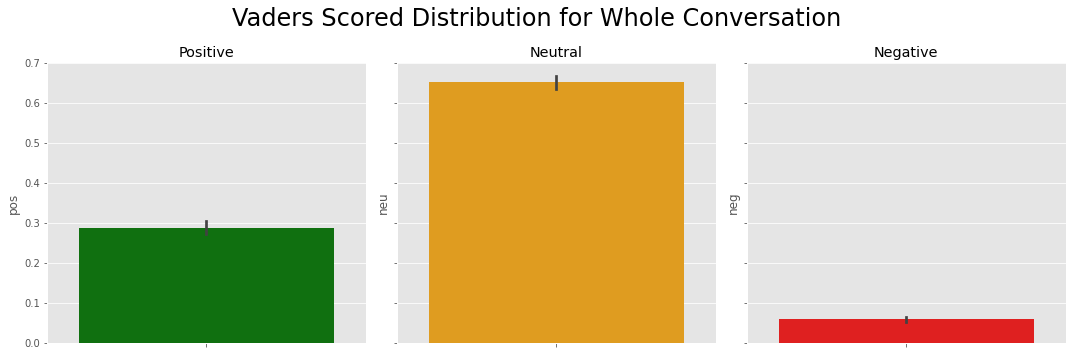

In [166]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.barplot(data=vaders,  y="pos", ax=axs[0], color="green")
sns.barplot(data=vaders,  y="neu", ax=axs[1], color="orange")
sns.barplot(data=vaders,  y="neg", ax=axs[2], color = "red")
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
fig.suptitle("Vaders Scored Distribution for Whole Conversation", fontsize=24)
plt.tight_layout()
plt.show()

### Seperate vaders df into Elon and Joe Dataframes

#### Vaders Joe Rogan

In [167]:
vaders_joe = vaders[vaders['Speaker']=="Joe Rogan"]
vaders_joe

,ID,neg,neu,pos,compound,Timestamp,Speaker,Text
0,0,0.000,0.455,0.545,0.9273,[00:00:00],Joe Rogan,"Ah, ha, ha, ha. Four, three, two, one, boom. T..."
2,2,0.000,0.610,0.390,0.4927,[00:00:10],Joe Rogan,It's very good to meet you.
4,4,0.195,0.569,0.236,0.1280,[00:00:12],Joe Rogan,And thanks for not lighting this place on fire.
6,6,0.000,0.934,0.066,0.3527,[00:00:16],Joe Rogan,"How does one, just in the middle of doing all ..."
8,8,0.000,1.000,0.000,0.0000,[00:01:02],Joe Rogan,"Now, who-"
...,...,...,...,...,...,...,...,...
1822,1822,0.116,0.731,0.153,0.4375,[02:36:21],Joe Rogan,I couldn't agree more. And I want to thank you...
1824,1824,0.000,1.000,0.000,0.0000,[02:36:40],Joe Rogan,And I believe it.
1826,1826,0.000,0.472,0.528,0.6801,[02:36:41],Joe Rogan,"I believe it's true too. So, thank you."
1828,1828,0.252,0.397,0.351,0.2500,[02:36:44],Joe Rogan,"All you assholes out there, be nice. Be nice, ..."


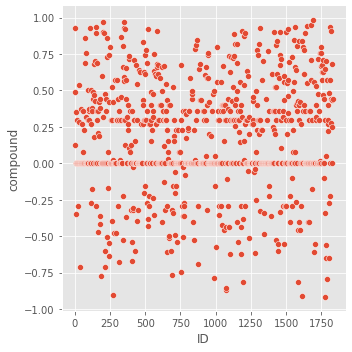

In [168]:
ax = sns.relplot(data=vaders_joe, x="ID", y="compound")

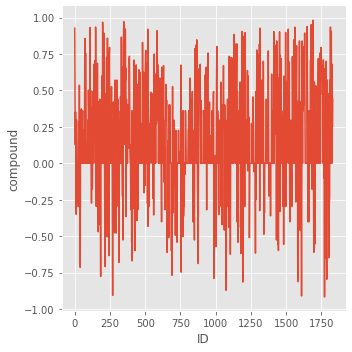

In [169]:
ax = sns.relplot(data=vaders_joe, x="ID", y="compound", kind="line")

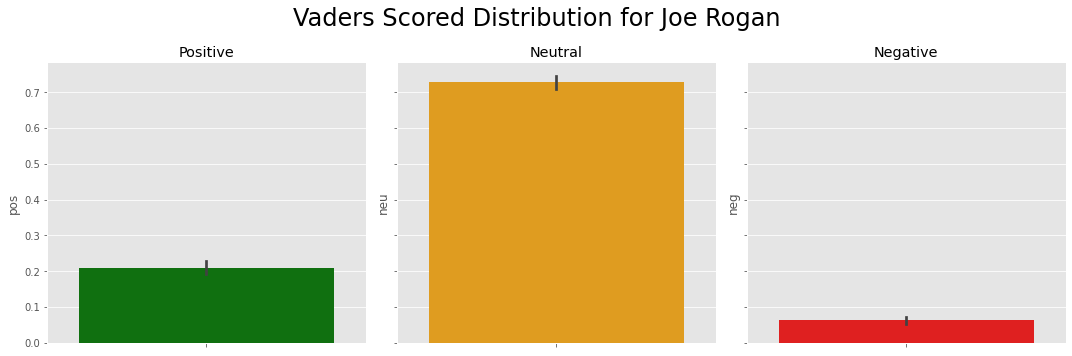

In [170]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.barplot(data=vaders_joe,  y="pos", ax=axs[0], color="green")
sns.barplot(data=vaders_joe,  y="neu", ax=axs[1], color="orange")
sns.barplot(data=vaders_joe,  y="neg", ax=axs[2], color = "red")
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
fig.suptitle("Vaders Scored Distribution for Joe Rogan", fontsize=24)
plt.tight_layout()
plt.show()

#### Vaders Elon Musk

In [171]:
vaders_elon = vaders[vaders['Speaker']=="Elon Musk"]
vaders_elon

,ID,neg,neu,pos,compound,Timestamp,Speaker,Text
1,1,0.000,0.250,0.750,0.4588,[00:00:09],Elon Musk,You're welcome.
3,3,0.000,0.588,0.412,0.4215,[00:00:11],Elon Musk,Nice to meet you too.
5,5,0.000,0.571,0.429,0.4588,[00:00:13],Elon Musk,You're welcome. That's coming later.
7,7,0.037,0.847,0.116,0.6077,[00:00:30],Elon Musk,"Well, the flame, we didn't put a lot of time i..."
9,9,0.049,0.951,0.000,-0.3182,[00:01:02],Elon Musk,"And then, we have a merchandise section that o..."
...,...,...,...,...,...,...,...,...
1821,1821,0.083,0.690,0.227,0.8476,[02:35:53],Elon Musk,"No. I think, you know, I think people should b..."
1823,1823,0.000,0.263,0.737,0.4215,[02:36:40],Elon Musk,It's true.
1825,1825,0.000,0.263,0.737,0.4215,[02:36:41],Elon Musk,It's true.
1827,1827,0.000,0.250,0.750,0.4588,[02:36:43],Elon Musk,You're welcome.


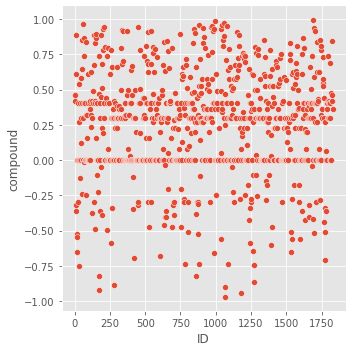

In [172]:
ax = sns.relplot(data=vaders_elon, x="ID", y="compound")

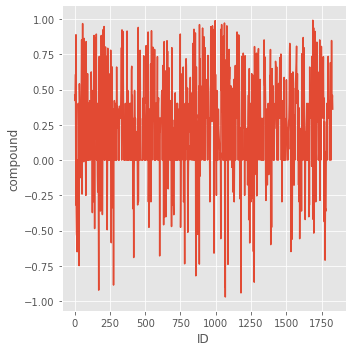

In [173]:
ax = sns.relplot(data=vaders_elon, x="ID", y="compound", kind="line")

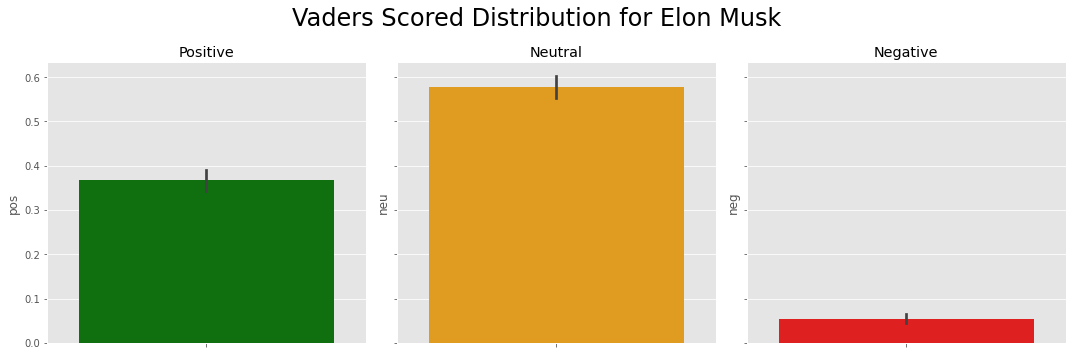

In [174]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.barplot(data=vaders_elon,  y="pos", ax=axs[0], color="green")
sns.barplot(data=vaders_elon,  y="neu", ax=axs[1], color="orange")
sns.barplot(data=vaders_elon,  y="neg", ax=axs[2], color = "red")
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
fig.suptitle("Vaders Scored Distribution for Elon Musk", fontsize=24)
plt.tight_layout()
plt.show()

## Roberta Pretrained Model

In [175]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [176]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [177]:
res={}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['ID']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1831 [00:00<?, ?it/s]

### Create Dataframe with both Vaders and Roberta results

In [181]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'ID'})
results_df = results_df.merge(df, how='left')

results_df

,ID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Timestamp,Speaker,Text
0,0,0.000,0.455,0.545,0.9273,0.001392,0.009808,0.988800,[00:00:00],Joe Rogan,"Ah, ha, ha, ha. Four, three, two, one, boom. T..."
1,1,0.000,0.250,0.750,0.4588,0.003367,0.086778,0.909855,[00:00:09],Elon Musk,You're welcome.
2,2,0.000,0.610,0.390,0.4927,0.001470,0.011406,0.987125,[00:00:10],Joe Rogan,It's very good to meet you.
3,3,0.000,0.588,0.412,0.4215,0.002190,0.039175,0.958635,[00:00:11],Elon Musk,Nice to meet you too.
4,4,0.195,0.569,0.236,0.1280,0.509518,0.384771,0.105711,[00:00:12],Joe Rogan,And thanks for not lighting this place on fire.
...,...,...,...,...,...,...,...,...,...,...,...
1826,1826,0.000,0.472,0.528,0.6801,0.001935,0.043308,0.954756,[02:36:41],Joe Rogan,"I believe it's true too. So, thank you."
1827,1827,0.000,0.250,0.750,0.4588,0.003367,0.086778,0.909855,[02:36:43],Elon Musk,You're welcome.
1828,1828,0.252,0.397,0.351,0.2500,0.283417,0.294291,0.422292,[02:36:44],Joe Rogan,"All you assholes out there, be nice. Be nice, ..."
1829,1829,0.000,0.545,0.455,0.3612,0.007994,0.182764,0.809243,[02:36:50],Elon Musk,"All right, thank you."


In [182]:
results_df.columns

Index(['ID', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Timestamp', 'Speaker',
       'Text'],
      dtype='object')

### Combine and Compare Models

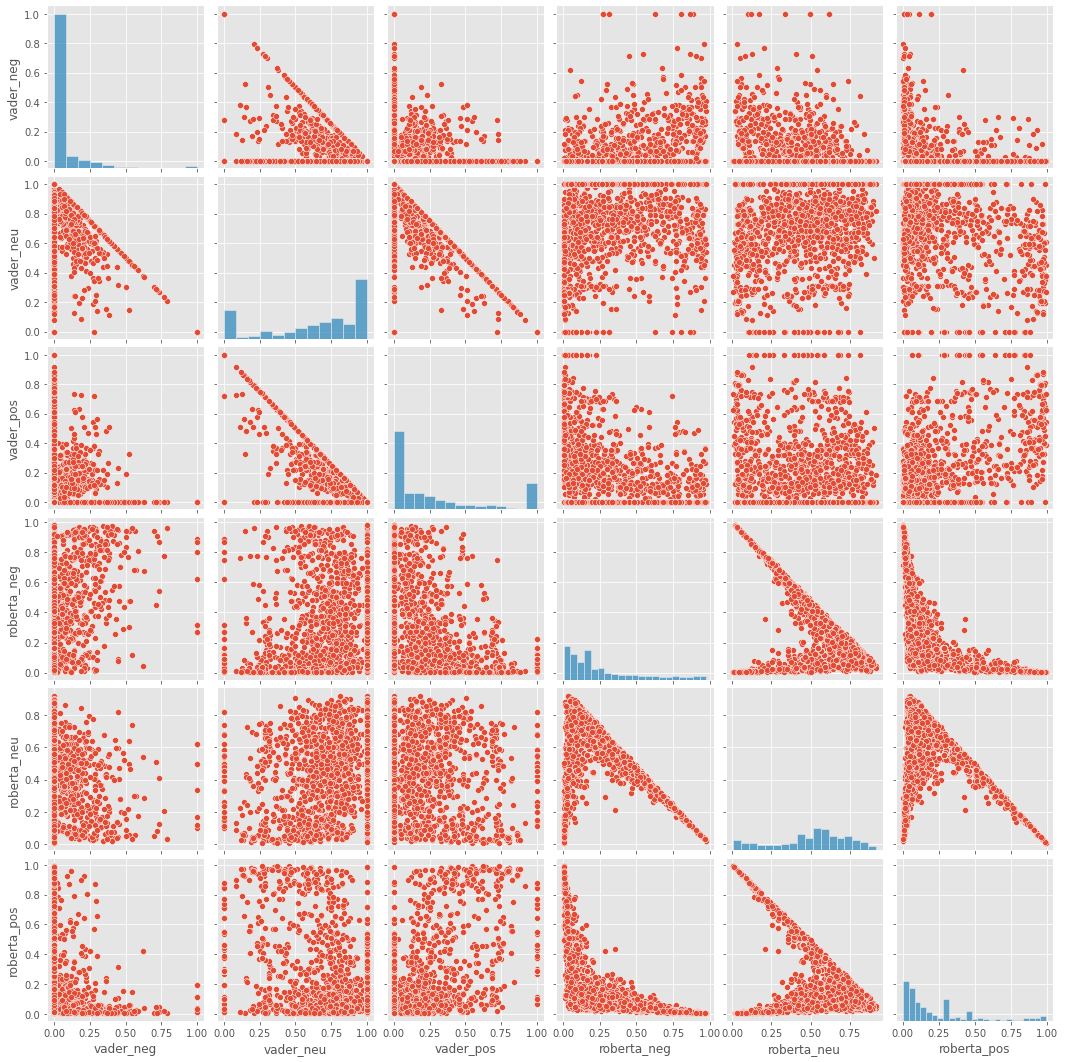

In [185]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            palette='tab10')
plt.show()